In [75]:
import pandas as pd
df = pd.read_csv("../Data/aggregated_spice_price_data_2019_2024.csv")
df

,Price Date,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal)
0,2019-10-31,8476.100000,9156.250000,8854.900000
1,2019-11-01,8362.619048,10080.666667,9385.238095
2,2019-11-02,8228.023256,9744.162791,9147.720930
3,2019-11-03,8620.000000,8881.111111,8768.888889
4,2019-11-04,8185.625000,9976.950000,9199.375000
...,...,...,...,...
1822,2024-10-26,9873.513514,11910.000000,11096.297297
1823,2024-10-27,10366.666667,10916.666667,10635.166667
1824,2024-10-28,10333.593750,11987.500000,11361.281250
1825,2024-10-29,9893.684211,11420.263158,10820.263158


In [76]:
df = df[["Price Date", "Modal Price (Rs./Quintal)"]]
df.loc[:, 'Price Date'] = pd.to_datetime(df['Price Date'])
df.set_index('Price Date', inplace=True)
index_dtype = df.index.dtype
print(f"Datatype of the index: {index_dtype}")

Datatype of the index: datetime64[ns]


/Users/tejas/PycharmProjects/Spice_Price_Forecast/.venv/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [77]:
import seaborn as sns
color_pal = sns.color_palette()

<Axes: title={'center': 'Modal Price'}, xlabel='Price Date'>

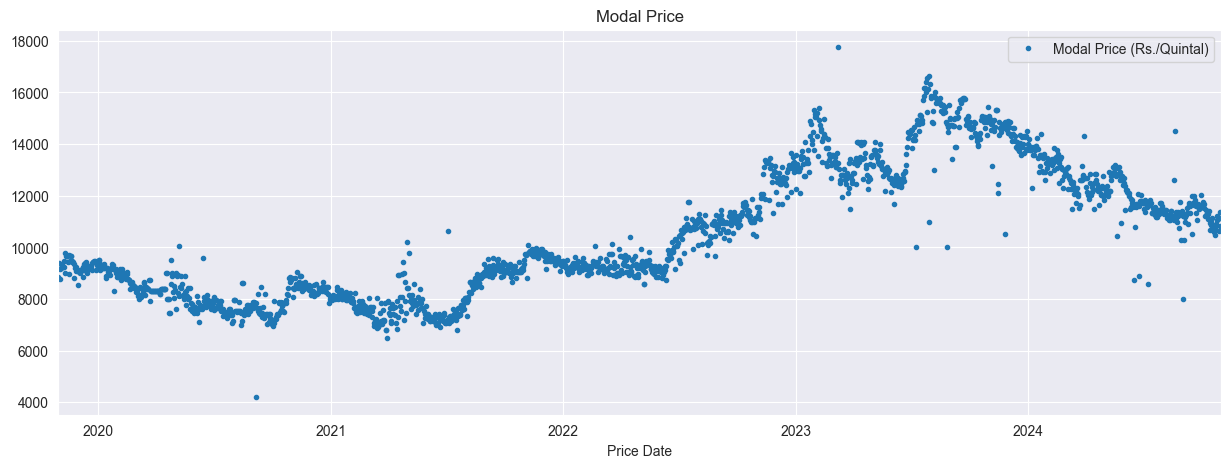

In [78]:
df.plot(style='.', figsize=(15, 5), color=color_pal[0], title="Modal Price", )

In [79]:
train_df = df.iloc[df.index<'01-01-2024']
test_df = df.iloc[df.index>='01-01-2024']

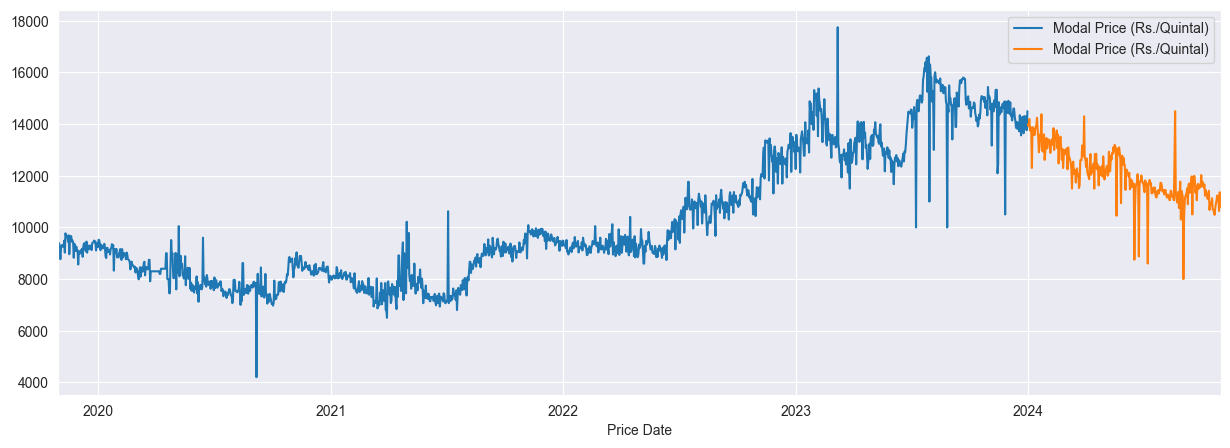

In [80]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
train_df.plot(ax=ax, label='Training set')
test_df.plot(ax=ax, label='Test set')
plt.show()


<Axes: xlabel='Price Date'>

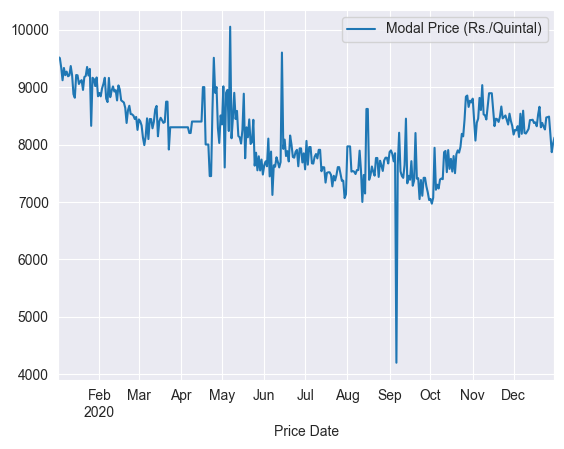

In [81]:
df.iloc[(df.index>'01-01-2020') & (df.index<'01-01-2021')].plot()

<Axes: xlabel='Price Date'>

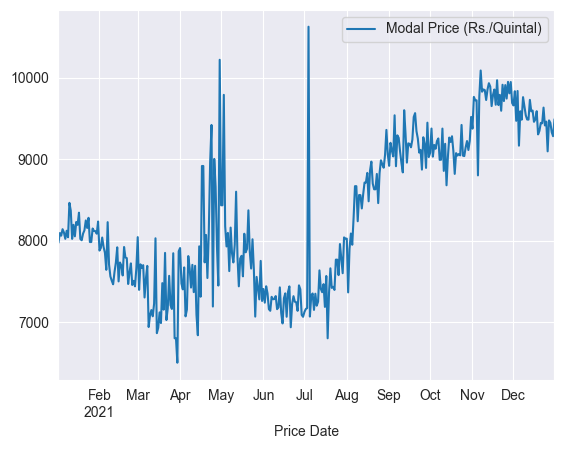

In [82]:
df.iloc[(df.index>'01-01-2021') & (df.index<'01-01-2022')].plot()

<Axes: xlabel='Price Date'>

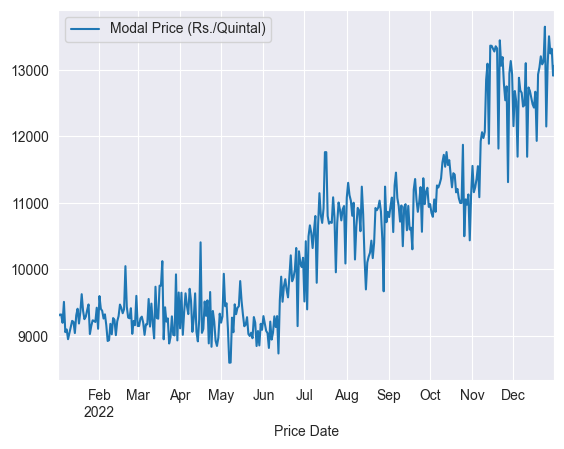

In [83]:
df.iloc[(df.index>'01-01-2022') & (df.index<'01-01-2023')].plot()

<Axes: xlabel='Price Date'>

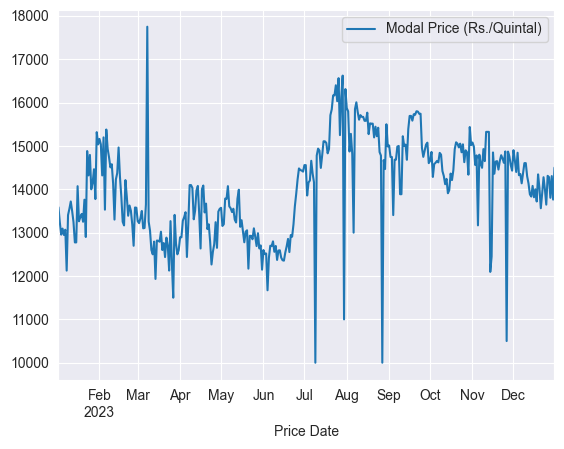

In [84]:
df.iloc[(df.index>'01-01-2023') & (df.index<'01-01-2024')].plot()

In [85]:
import pandas as pd

target_map = df['Modal Price (Rs./Quintal)'].to_dict()

def create_features(df):
    """
    Create time series features based on time series index for weekly forecasting.
    """
    df = df.copy()

    # Time-based features
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    # Lag features
    df['lag90'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    df['lag180'] = (df.index - pd.Timedelta('180 days')).map(target_map)
    df['lag270'] = (df.index - pd.Timedelta('270 days')).map(target_map)

    # Rolling window features
    for window in [90, 180, 270]:
        df[f'rolling_mean_{window}'] = df['Modal Price (Rs./Quintal)'].rolling(window=window, min_periods=1).mean()
        df[f'rolling_median_{window}'] = df['Modal Price (Rs./Quintal)'].rolling(window=window, min_periods=1).median()
        df[f'rolling_std_{window}'] = df['Modal Price (Rs./Quintal)'].rolling(window=window, min_periods=1).std()

    # Exponential moving averages
    df['ema90'] = df['Modal Price (Rs./Quintal)'].ewm(span=90, adjust=False).mean()
    df['ema180'] = df['Modal Price (Rs./Quintal)'].ewm(span=180, adjust=False).mean()

    # Moving averages
    df['moving_avg_90'] = df['Modal Price (Rs./Quintal)'].rolling(window=90, min_periods=1).mean()
    df['moving_avg_180'] = df['Modal Price (Rs./Quintal)'].rolling(window=180, min_periods=1).mean()

    # Other statistical features
    df['max_270'] = df['Modal Price (Rs./Quintal)'].rolling(window=270, min_periods=1).max()
    df['min_270'] = df['Modal Price (Rs./Quintal)'].rolling(window=270, min_periods=1).min()
    df['range_270'] = df['max_270'] - df['min_270']

    return df


In [86]:
df = create_features(df)
df

,Modal Price (Rs./Quintal),dayofweek,quarter,month,year,dayofyear,weekofyear,lag90,lag180,lag270,...,rolling_mean_270,rolling_median_270,rolling_std_270,ema90,ema180,moving_avg_90,moving_avg_180,max_270,min_270,range_270
Price Date,,,,,,,,,,,,,,,,,,,,,
2019-10-31,8854.900000,3,4,10,2019,304,44,NaN,NaN,NaN,...,8854.900000,8854.900000,NaN,8854.900000,8854.900000,8854.900000,8854.900000,8854.900000,8854.900000,0.000000
2019-11-01,9385.238095,4,4,11,2019,305,44,NaN,NaN,NaN,...,9120.069048,9120.069048,375.005663,8866.555782,8860.760089,9120.069048,9120.069048,9385.238095,8854.900000,530.338095
2019-11-02,9147.720930,5,4,11,2019,306,44,NaN,NaN,NaN,...,9129.286342,9147.720930,265.649204,8872.735236,8863.930927,9129.286342,9129.286342,9385.238095,8854.900000,530.338095
2019-11-03,8768.888889,6,4,11,2019,307,44,NaN,NaN,NaN,...,9039.186979,9001.310465,281.989209,8870.452899,8862.880739,9039.186979,9039.186979,9385.238095,8768.888889,616.349206
2019-11-04,9199.375000,0,4,11,2019,308,45,NaN,NaN,NaN,...,9071.224583,9147.720930,254.500444,8877.681956,8866.598908,9071.224583,9071.224583,9385.238095,8768.888889,616.349206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-26,11096.297297,5,4,10,2024,300,43,11725.500000,12300.272727,13462.933333,...,11932.489954,11796.138393,879.856379,11307.808446,11626.951947,11290.763765,11575.408007,14500.000000,8000.000000,6500.000000
2024-10-27,10635.166667,6,4,10,2024,301,43,11622.321429,11854.523810,13055.937500,...,11923.524136,11777.856250,880.699323,11293.025110,11615.992994,11279.795379,11568.633801,14500.000000,8000.000000,6500.000000
2024-10-28,11361.281250,0,4,10,2024,302,44,11389.678571,12038.842105,13227.105263,...,11916.613676,11768.650000,877.747875,11294.525245,11613.178499,11279.479853,11564.869574,14500.000000,8000.000000,6500.000000


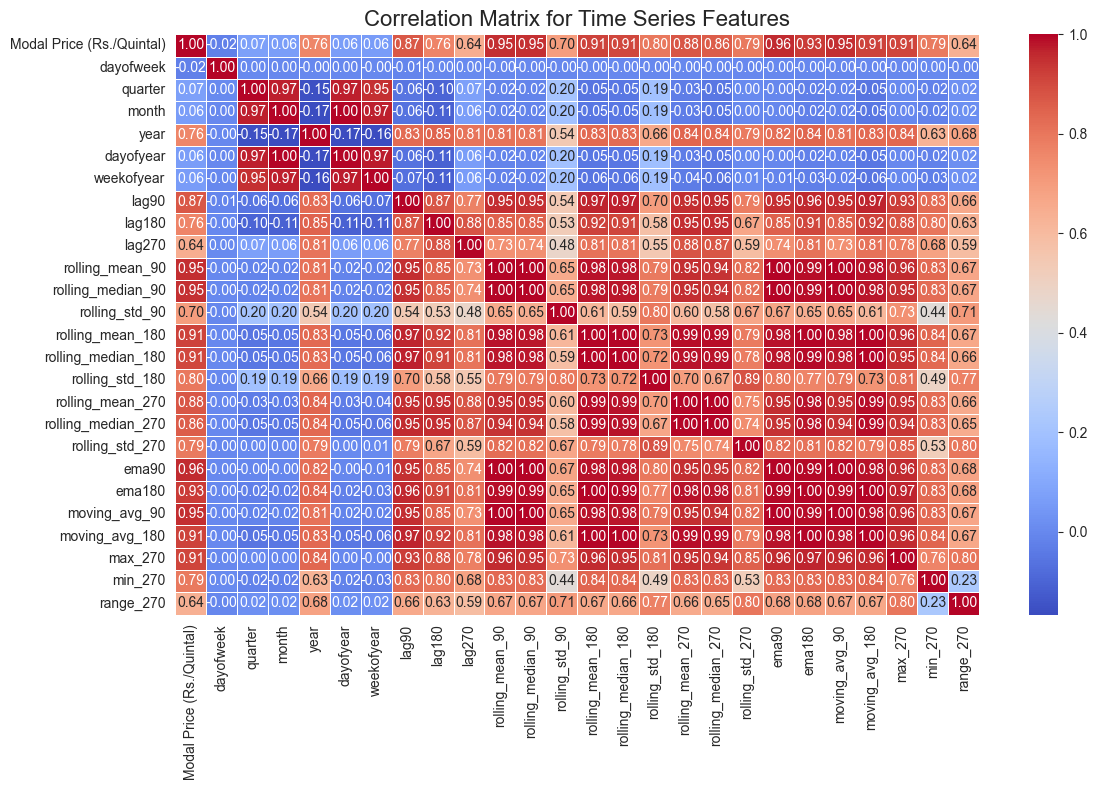

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your dataframe after applying create_features()
df_with_features = create_features(df)

# Calculate the correlation matrix
correlation_matrix = df_with_features.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Time Series Features', fontsize=16)
plt.tight_layout()
plt.show()


In [88]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Custom metrics
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mdape(y_true, y_pred):
    """Median Absolute Percentage Error"""
    return 100 * np.median(np.abs((y_pred - y_true) / y_true))

def gmrae(y_true, y_pred):
    """Geometric Mean Relative Absolute Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true - np.mean(y_true))
    ratio = numerator / denominator
    return np.exp(np.mean(np.log(ratio + 1e-10)))

# Define target and features
y = df['Modal Price (Rs./Quintal)']
feature_columns = [col for col in df.columns if col != 'Modal Price (Rs./Quintal)']
X = df[feature_columns]

# Define the base XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Split into 5 sets, each of 30 days
n_splits = 5
test_days = 180

# Calculate total number of splits and test range
total_days = len(y)
split_size = total_days // n_splits

metrics_per_split = []

# Time-based split
for i in range(n_splits):
    # Define train and test indices
    train_end = split_size * (i + 1) - test_days
    test_start = train_end
    test_end = split_size * (i + 1)

    X_train, X_test = X.iloc[:train_end], X.iloc[test_start:test_end]
    y_train, y_test = y.iloc[:train_end], y.iloc[test_start:test_end]

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Predict
    y_pred = xgb_model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_absolute_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    smape_val = smape(y_test, y_pred)
    mdape_val = mdape(y_test, y_pred)
    gmrae_val = gmrae(y_test, y_pred)

    metrics_per_split.append({
        'Split': i + 1,
        'RMSE': rmse,
        'MAE': mae,
        'SMAPE': smape_val,
        'MDAPE': mdape_val,
        'GMRAE': gmrae_val
    })

# Print metrics for each split
for metrics in metrics_per_split:
    print(f"Split {metrics['Split']}:")
    for metric_name, metric_value in metrics.items():
        if metric_name != 'Split':
            print(f"  {metric_name}: {metric_value:.4f}")


Split 1:
  RMSE: 34.0668
  MAE: 1160.5488
  SMAPE: 14.1135
  MDAPE: 15.6520
  GMRAE: 4.5066
Split 2:
  RMSE: 31.2542
  MAE: 976.8233
  SMAPE: 11.9033
  MDAPE: 11.3895
  GMRAE: 1.0706
Split 3:
  RMSE: 26.9962
  MAE: 728.7944
  SMAPE: 7.0580
  MDAPE: 6.6109
  GMRAE: 0.7819
Split 4:
  RMSE: 36.6258
  MAE: 1341.4472
  SMAPE: 9.5660
  MDAPE: 9.3248
  GMRAE: 1.4688
Split 5:
  RMSE: 36.1266
  MAE: 1305.1312
  SMAPE: 10.8526
  MDAPE: 11.1821
  GMRAE: 3.2951


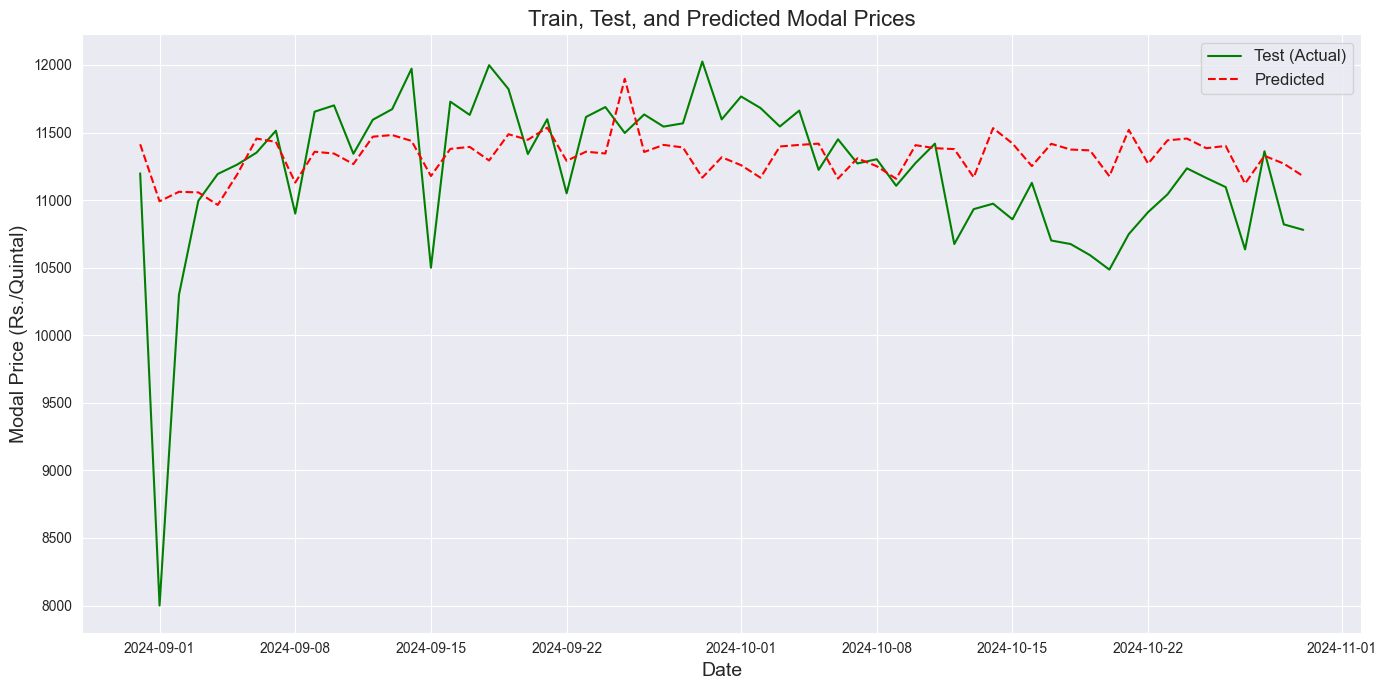

Metrics:
Mean Absolute Error (MAE): 372.0884
Symmetric Mean Absolute Percentage Error (SMAPE): 3.3902
Median Absolute Percentage Error (MDAPE): 2.3873
Geometric Mean Relative Absolute Error (GMRAE): 0.9793


In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Assuming `df` contains your data, and it is already prepared with features and target column
# Define train and test data
train_data = df.loc[:'2024-08-30']
test_data = df.loc['2024-08-31':'2024-10-31']

# Extract features and target
feature_columns = [col for col in df.columns if col != 'Modal Price (Rs./Quintal)']
X_train = train_data[feature_columns]
y_train = train_data['Modal Price (Rs./Quintal)']
X_test = test_data[feature_columns]
y_test = test_data['Modal Price (Rs./Quintal)']
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Add predictions to test data
test_data = test_data.copy()  # Avoid SettingWithCopyWarning
test_data['Predicted'] = y_pred

# Plot
plt.figure(figsize=(14, 7))


# Plot test data (actual values)
plt.plot(test_data.index, test_data['Modal Price (Rs./Quintal)'], label='Test (Actual)', color='green')

# Plot predictions
plt.plot(test_data.index, test_data['Predicted'], label='Predicted', color='red', linestyle='--')

# Add title and labels
plt.title("Train, Test, and Predicted Modal Prices", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Modal Price (Rs./Quintal)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Metrics Calculation
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    non_zero_mask = (np.abs(y_true) + np.abs(y_pred)) > 0  # Avoid division by zero
    return 100 * np.mean(2 * np.abs(y_pred[non_zero_mask] - y_true[non_zero_mask]) /
                         (np.abs(y_true[non_zero_mask]) + np.abs(y_pred[non_zero_mask])))

def mdape(y_true, y_pred):
    """Median Absolute Percentage Error"""
    non_zero_mask = y_true != 0  # Avoid division by zero
    return 100 * np.median(np.abs((y_pred[non_zero_mask] - y_true[non_zero_mask]) / y_true[non_zero_mask]))

def gmrae(y_true, y_pred):
    """Geometric Mean Relative Absolute Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true - np.mean(y_true))
    ratio = numerator / (denominator + 1e-10)  # Avoid division by zero
    return np.exp(np.mean(np.log(ratio + 1e-10)))

mae = mean_absolute_error(y_test, y_pred)
smape_val = smape(y_test.values, y_pred)
mdape_val = mdape(y_test.values, y_pred)
gmrae_val = gmrae(y_test.values, y_pred)

# Print metrics
print("Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_val:.4f}")
print(f"Median Absolute Percentage Error (MDAPE): {mdape_val:.4f}")
print(f"Geometric Mean Relative Absolute Error (GMRAE): {gmrae_val:.4f}")


In [90]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Assuming X_train, y_train, X_test, and y_test are defined
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Generate all combinations of hyperparameters
param_combinations = list(product(
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['n_estimators'],
    param_grid['subsample'],
    param_grid['colsample_bytree'],
    param_grid['gamma']
))

# Store results for comparison
results = []

# Iterate through each parameter combination
for params in param_combinations:
    # Unpack parameters
    learning_rate, max_depth, n_estimators, subsample, colsample_bytree, gamma = params

    # Define the model with the current parameters
    model = XGBRegressor(
        objective='reg:squarederror',
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        random_state=42
    )

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Evaluate performance using MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Save the results
    results.append({
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'gamma': gamma,
        'mae': mae
    })

    print(f"Evaluated params: {params} | MAE: {mae:.4f}")

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Find the best parameters (lowest MAE)
best_params = results_df.loc[results_df['mae'].idxmin()]

# Print the best parameters and corresponding score
print("\nBest Parameters:")
print(best_params)

# Train the final model with the best parameters
final_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    n_estimators=int(best_params['n_estimators']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)

final_mae = mean_absolute_error(y_test, y_pred_final)
print(f"\nFinal Model MAE: {final_mae:.4f}")

# Output the final predictions for visualization or further analysis
print("\nFinal Predictions:")
print(pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred_final}, index=y_test.index).head())


Evaluated params: (0.01, 3, 50, 0.6, 0.6, 0) | MAE: 479.9820
Evaluated params: (0.01, 3, 50, 0.6, 0.6, 0.1) | MAE: 479.9820
Evaluated params: (0.01, 3, 50, 0.6, 0.6, 0.2) | MAE: 479.9820
Evaluated params: (0.01, 3, 50, 0.6, 0.8, 0) | MAE: 481.4306
Evaluated params: (0.01, 3, 50, 0.6, 0.8, 0.1) | MAE: 481.4306
Evaluated params: (0.01, 3, 50, 0.6, 0.8, 0.2) | MAE: 481.4306
Evaluated params: (0.01, 3, 50, 0.6, 1.0, 0) | MAE: 489.1392
Evaluated params: (0.01, 3, 50, 0.6, 1.0, 0.1) | MAE: 489.1392
Evaluated params: (0.01, 3, 50, 0.6, 1.0, 0.2) | MAE: 489.1392
Evaluated params: (0.01, 3, 50, 0.8, 0.6, 0) | MAE: 472.2125
Evaluated params: (0.01, 3, 50, 0.8, 0.6, 0.1) | MAE: 472.2125
Evaluated params: (0.01, 3, 50, 0.8, 0.6, 0.2) | MAE: 472.2125
Evaluated params: (0.01, 3, 50, 0.8, 0.8, 0) | MAE: 480.9938
Evaluated params: (0.01, 3, 50, 0.8, 0.8, 0.1) | MAE: 480.9938
Evaluated params: (0.01, 3, 50, 0.8, 0.8, 0.2) | MAE: 480.9938
Evaluated params: (0.01, 3, 50, 0.8, 1.0, 0) | MAE: 485.1634
Eval

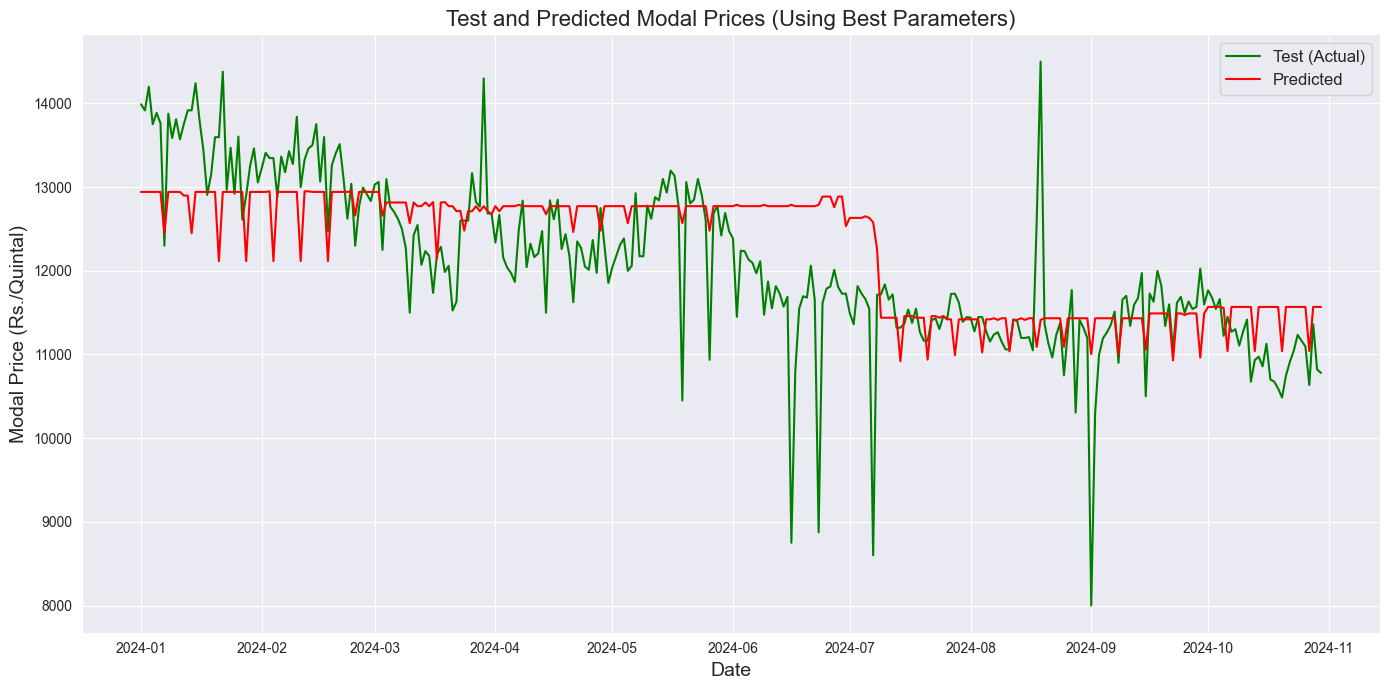

Metrics:
Mean Absolute Error (MAE): 531.8950
Symmetric Mean Absolute Percentage Error (SMAPE): 4.4063
Median Absolute Percentage Error (MDAPE): 3.1690
Geometric Mean Relative Absolute Error (GMRAE): 0.5379


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Assuming `df` contains your data, and it is already prepared with features and target column
# Define train and test data
train_data = df.loc[:'2023-12-31']
test_data = df.loc['2024-01-01':'2024-10-31']

# Extract features and target
feature_columns = [col for col in df.columns if col != 'Modal Price (Rs./Quintal)']
X_train = train_data[feature_columns]
y_train = train_data['Modal Price (Rs./Quintal)']
X_test = test_data[feature_columns]
y_test = test_data['Modal Price (Rs./Quintal)']

# Best parameters from hyperparameter tuning
best_params = {
    'learning_rate': 0.01,
    'max_depth': 7,
    'n_estimators': 100,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0.0,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize the model with the best parameters
model = XGBRegressor(**best_params)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Add predictions to test data
test_data = test_data.copy()  # Avoid SettingWithCopyWarning
test_data['Predicted'] = y_pred

# Plot
plt.figure(figsize=(14, 7))

# Plot test data (actual values)
plt.plot(test_data.index, test_data['Modal Price (Rs./Quintal)'], label='Test (Actual)', color='green')

# Plot predictions
plt.plot(test_data.index, test_data['Predicted'], label='Predicted', color='red')

# Add title and labels
plt.title("Test and Predicted Modal Prices (Using Best Parameters)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Modal Price (Rs./Quintal)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Metrics Calculation
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    non_zero_mask = (np.abs(y_true) + np.abs(y_pred)) > 0  # Avoid division by zero
    return 100 * np.mean(2 * np.abs(y_pred[non_zero_mask] - y_true[non_zero_mask]) /
                         (np.abs(y_true[non_zero_mask]) + np.abs(y_pred[non_zero_mask])))

def mdape(y_true, y_pred):
    """Median Absolute Percentage Error"""
    non_zero_mask = y_true != 0  # Avoid division by zero
    return 100 * np.median(np.abs((y_pred[non_zero_mask] - y_true[non_zero_mask]) / y_true[non_zero_mask]))

def gmrae(y_true, y_pred):
    """Geometric Mean Relative Absolute Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true - np.mean(y_true))
    ratio = numerator / (denominator + 1e-10)  # Avoid division by zero
    return np.exp(np.mean(np.log(ratio + 1e-10)))

mae = mean_absolute_error(y_test, y_pred)
smape_val = smape(y_test.values, y_pred)
mdape_val = mdape(y_test.values, y_pred)
gmrae_val = gmrae(y_test.values, y_pred)

# Print metrics
print("Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_val:.4f}")
print(f"Median Absolute Percentage Error (MDAPE): {mdape_val:.4f}")
print(f"Geometric Mean Relative Absolute Error (GMRAE): {gmrae_val:.4f}")


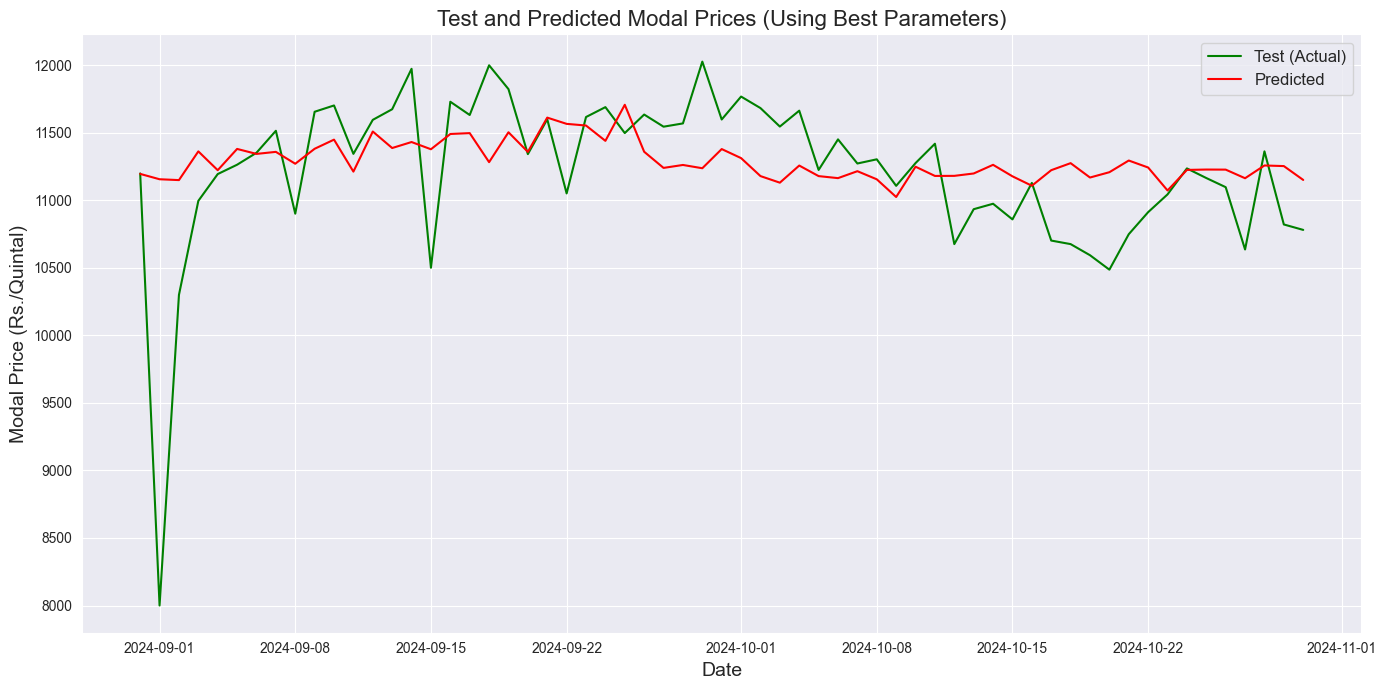

Metrics:
Mean Absolute Error (MAE): 342.5535
Symmetric Mean Absolute Percentage Error (SMAPE): 3.1319
Median Absolute Percentage Error (MDAPE): 2.4171
Geometric Mean Relative Absolute Error (GMRAE): 0.7221


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Assuming `df` contains your data, and it is already prepared with features and target column
# Define train and test data
train_data = df.loc[:'2024-08-30']
test_data = df.loc['2024-08-31':'2024-10-31']

# Extract features and target
feature_columns = [col for col in df.columns if col != 'Modal Price (Rs./Quintal)']
X_train = train_data[feature_columns]
y_train = train_data['Modal Price (Rs./Quintal)']
X_test = test_data[feature_columns]
y_test = test_data['Modal Price (Rs./Quintal)']

# Best parameters from hyperparameter tuning
best_params = {
    'learning_rate': 0.2,
    'max_depth': 7,
    'n_estimators': 150,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'gamma': 0.0,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize the model with the best parameters
model = XGBRegressor(**best_params)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Add predictions to test data
test_data = test_data.copy()  # Avoid SettingWithCopyWarning
test_data['Predicted'] = y_pred

# Plot
plt.figure(figsize=(14, 7))

# Plot test data (actual values)
plt.plot(test_data.index, test_data['Modal Price (Rs./Quintal)'], label='Test (Actual)', color='green')

# Plot predictions
plt.plot(test_data.index, test_data['Predicted'], label='Predicted', color='red')

# Add title and labels
plt.title("Test and Predicted Modal Prices (Using Best Parameters)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Modal Price (Rs./Quintal)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Metrics Calculation
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    non_zero_mask = (np.abs(y_true) + np.abs(y_pred)) > 0  # Avoid division by zero
    return 100 * np.mean(2 * np.abs(y_pred[non_zero_mask] - y_true[non_zero_mask]) /
                         (np.abs(y_true[non_zero_mask]) + np.abs(y_pred[non_zero_mask])))

def mdape(y_true, y_pred):
    """Median Absolute Percentage Error"""
    non_zero_mask = y_true != 0  # Avoid division by zero
    return 100 * np.median(np.abs((y_pred[non_zero_mask] - y_true[non_zero_mask]) / y_true[non_zero_mask]))

def gmrae(y_true, y_pred):
    """Geometric Mean Relative Absolute Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true - np.mean(y_true))
    ratio = numerator / (denominator + 1e-10)  # Avoid division by zero
    return np.exp(np.mean(np.log(ratio + 1e-10)))

mae = mean_absolute_error(y_test, y_pred)
smape_val = smape(y_test.values, y_pred)
mdape_val = mdape(y_test.values, y_pred)
gmrae_val = gmrae(y_test.values, y_pred)

# Print metrics
print("Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_val:.4f}")
print(f"Median Absolute Percentage Error (MDAPE): {mdape_val:.4f}")
print(f"Geometric Mean Relative Absolute Error (GMRAE): {gmrae_val:.4f}")


In [93]:
df.index.max()

Timestamp('2024-10-30 00:00:00')

In [94]:
def calculate_monthly_metrics(test_data, y_test, y_pred):
    # Ensure the index is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(test_data.index):
        raise TypeError("The index of test_data must be a datetime type.")

    monthly_metrics = []

    # Group by 1-month periods using the index
    for period, period_data in test_data.groupby(pd.Grouper(freq='3ME')):
        # Get the integer positions of the indices using get_indexer
        positions = test_data.index.get_indexer(period_data.index)

        # Get actual and predicted values for the current 1-month period
        period_y_true = y_test.iloc[positions]  # Use iloc for integer-based indexing
        period_y_pred = y_pred[positions]  # Use integer-based indexing for numpy array

        # Calculate the metrics for this period
        mae_period = mean_absolute_error(period_y_true, period_y_pred)
        smape_period = smape(period_y_true.values, period_y_pred)
        mdape_period = mdape(period_y_true.values, period_y_pred)
        gmrae_period = gmrae(period_y_true.values, period_y_pred)

        # Store the metrics for the 1-month period
        monthly_metrics.append({
            'Period': period,
            'MAE': mae_period,
            'SMAPE': smape_period,
            'MDAPE': mdape_period,
            'GMRAE': gmrae_period
        })

    return pd.DataFrame(monthly_metrics)

# Calculate monthly metrics
monthly_metrics_df = calculate_monthly_metrics(test_data, y_test, y_pred)

# Print the 1-month metrics
print("1-Month Period Metrics:")
print(monthly_metrics_df)


1-Month Period Metrics:
      Period         MAE     SMAPE     MDAPE         GMRAE
0 2024-08-31    3.561058  0.031806  0.031801  3.561058e+10
1 2024-11-30  348.203347  3.183526  2.438283  7.361820e-01
